In [74]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from heapq import nlargest
earlystopper = [EarlyStopping(monitor='val_acc', patience=1, verbose=1,restore_best_weights=True)]

from wordcloud import WordCloud
import re
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
#from skmultilearn.adapt import mlknn
#from skmultilearn.problem_transform import ClassifierChain
#from skmultilearn.problem_transform import BinaryRelevance
#from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier

In [75]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)


def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)


def generate_data(sample):
  dict={}
  for t in sample['Text']:
    j=t.split()
    for item in j:
      try:
        dict[item]=dict[item]+1
      except KeyError as e:
        dict[item]=1
  
  dict_sorted_keys = sorted(dict, key=dict.get, reverse=True)
  list_of_review=[]
  for t in sample['Text']:
    j=t.split()
    temp=[]
    for item in j:
      index=dict_sorted_keys.index(item)
      if(index<top_words):
        temp.append(index)
      else:
        temp.append(0)
    list_of_review.append(temp)
  return list_of_review

def plot_bar_x(index,no_movies,item):
    # this is for plotting purpose
   # index = np.arange(len(label))
    plt.bar(index, no_movies)
    plt.xlabel('class_label', fontsize=10)
    plt.ylabel('feature = ' + item)
    plt.xticks(index, fontsize=10, rotation=30)
    plt.title('EDA')
    plt.show()


Tables in the databse:
QuestionsProcessed
Tables in the databse:
QuestionsProcessed


In [64]:
#Taking 0.5 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [48]:
preprocessed_data.head()
preprocessed_data = preprocessed_data.head(10000)

In [49]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 10000
number of dimensions : 2


In [50]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [51]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [52]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 900 out of  10000


In [53]:
train_datasize = 8000
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - train_datasize)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [54]:
print(y_train.shape)
print(y_test.shape)
print(x_test.shape)

(8000, 500)
(2000, 500)
(2000, 2)


In [55]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (8000, 500)
Number of data points in test data : (2000, 500)


In [56]:
tags = preprocessed_data['tags']
dict={}
for item in tags:
    taglist = item.split()
    for i in taglist:
        if i in dict.keys():
            dict[i] = dict[i]+1
        else:
            dict[i] = 1

In [57]:
n_largest = sorted(dict, key=lambda k: dict[k],reverse=True)[0:10]

In [58]:
n_largest

['c#',
 'java',
 'javascript',
 'android',
 'php',
 'c++',
 '.net',
 'asp.net',
 'python',
 'jquery']

# EDA 
1) Taken top features and top class label and plotted the count bar graph.

In [60]:
tfidf = TfidfVectorizer(max_features=500,stop_words = "english")
response = tfidf.fit_transform(preprocessed_data['question'])

feature_array = np.array(tfidf.get_feature_names())
tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

n = 10


In [61]:
top_n = feature_array[tfidf_sorting][:n]
top_n

array(['button', 'work', 'tab', 'replac', 'activ', 'avail', 'custom',
       'tri', 'view', 'appreci'], dtype='<U11')

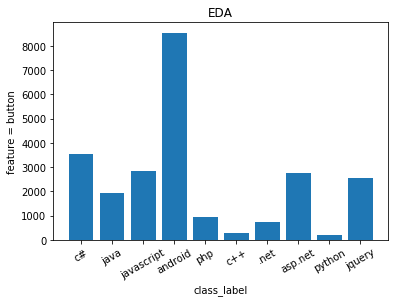

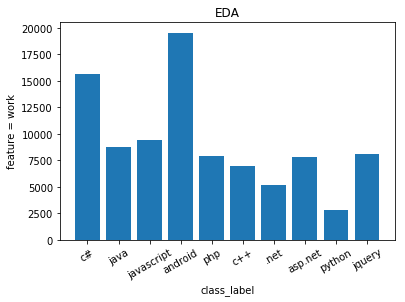

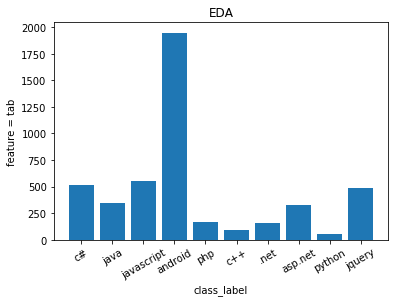

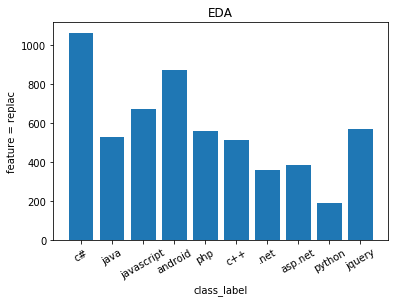

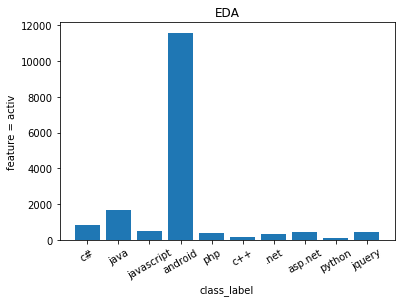

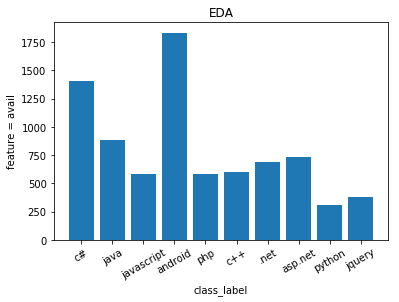

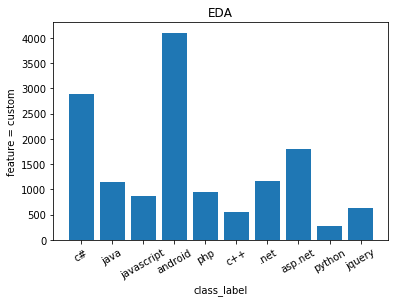

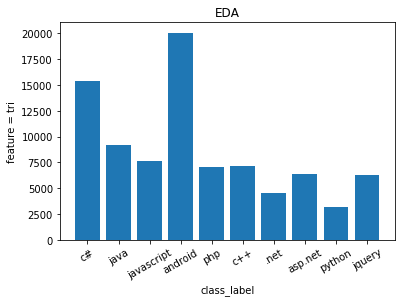

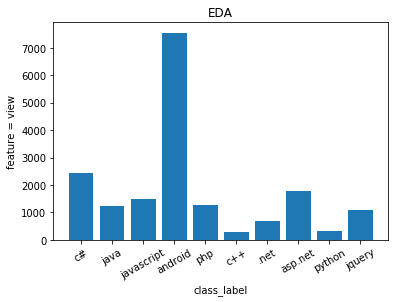

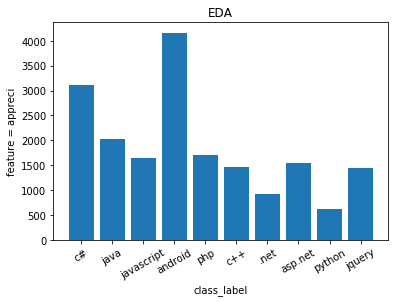

In [73]:
c

# sgd classifier

In [12]:
start = datetime.now()
#vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
#                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
                             

vectorizer = CountVectorizer(min_df=0.00009, max_features=200, \
                             tokenizer = lambda x: x.split(), ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.fit_transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:06.466981


In [13]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha = 0.00001, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.017
Hamming loss  0.016582
Micro-average quality numbers
Precision: 0.0081, Recall: 0.0292, F1-measure: 0.0127
Macro-average quality numbers
Precision: 0.0044, Recall: 0.0103, F1-measure: 0.0051
              precision    recall  f1-score   support

           0       0.04      0.08      0.05        97
           1       0.04      0.02      0.03       140
           2       0.08      0.02      0.04       125
           3       0.10      0.10      0.10        91
           4       0.06      0.06      0.06        88
           5       0.08      0.08      0.08       136
           6       0.00      0.00      0.00        25
           7       0.02      0.07      0.03        27
           8       0.00      0.00      0.00        88
           9       0.06      0.05      0.06        81
          10       0.05      0.03      0.04        61
          11       0.02      0.01      0.01        82
          12       0.01      0.03      0.02        40
          13       0.03      0.09  

/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklear

# LogisticRegression

In [14]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'), n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.0545
Hamming loss  0.005863
Micro-average quality numbers
Precision: 0.0111, Recall: 0.0068, F1-measure: 0.0085
Macro-average quality numbers
Precision: 0.0043, Recall: 0.0026, F1-measure: 0.0026
              precision    recall  f1-score   support

           0       0.03      0.01      0.02        97
           1       0.00      0.00      0.00       140
           2       0.12      0.01      0.02       125
           3       0.12      0.05      0.07        91
           4       0.12      0.03      0.05        88
           5       0.17      0.03      0.05       136
           6       0.00      0.00      0.00        25
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00        88
           9       0.00      0.00      0.00        81
          10       0.00      0.00      0.00        61
          11       0.00      0.00      0.00        82
          12       0.00      0.00      0.00        40
          13       0.05      0.03 

/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sk

In [15]:
print(x_train_multilabel.shape)
print(y_train.shape)

(8000, 200)
(8000, 500)


# GridSearchCV

In [16]:
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'),n_jobs=-1)
alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,2,10,100,10000,100000,50000,55000,600000,65000,100000] #0.01,0.1,1,10,100,1000,10000]
#alpha_list=[0.00001,0.0001,0.001]
parameters = {'estimator__C':alpha_list}
gs2 = GridSearchCV(classifier_2, param_grid = parameters, cv=2,scoring='f1_micro',n_jobs=-1)
gs2.fit(x_train_multilabel, y_train)




GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=-1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'estimator__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2, 10, 100, 10000, 100000, 50000, 55000, 600000, 65000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [20]:
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'),n_jobs=-1)
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))

Accuracy : 0.0545
Hamming loss  0.005864


In [21]:
print(gs2.best_score_)
print(gs2.best_params_)

0.11839579159962253
{'estimator__C': 1}


In [22]:
result = pd.DataFrame(gs2.cv_results_)
result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__C,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,3.989374,0.083900,0.354840,0.094048,1e-05,{'estimator__C': 1e-05},0.00000,0.000000,0.000000,0.000000,14,0.000000,0.000000,0.000000,0.000000
1,3.927281,0.038706,0.267864,0.004782,0.0001,{'estimator__C': 0.0001},0.00000,0.000000,0.000000,0.000000,14,0.000000,0.000000,0.000000,0.000000
2,9.700823,0.267445,0.375620,0.120557,0.001,{'estimator__C': 0.001},0.00000,0.000000,0.000000,0.000000,14,0.000000,0.000000,0.000000,0.000000
3,9.593025,0.306578,0.239119,0.057310,0.01,{'estimator__C': 0.01},0.03689,0.041368,0.039129,0.002239,13,0.033524,0.047789,0.040656,0.007132
4,10.851459,0.313321,0.544991,0.021015,0.1,{'estimator__C': 0.1},0.09525,0.083054,0.089152,0.006098,4,0.109868,0.105780,0.107824,0.002044


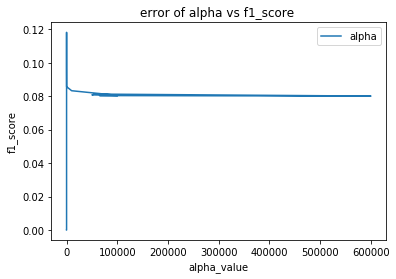

In [23]:
plt.plot(alpha_list,result['split0_test_score'],label='alpha')
plt.title("error of alpha vs f1_score ")
plt.xlabel('alpha_value')
plt.ylabel('f1_score')
plt.legend()
plt.show()


# SGD classifier

In [24]:
classifier_3 = OneVsRestClassifier(linear_model.SGDClassifier(penalty='l1',loss="hinge"),n_jobs=-1)

In [25]:
alpha_list=[0.00001,0.0001,0.001,0.01,0.1,1,2,10,100,10000,100000,50000,55000,600000,65000,100000] #0.01,0.1,1,10,100,1000,10000]

In [26]:
parameters = {'estimator__alpha':alpha_list}
gs3 = GridSearchCV(classifier_3, param_grid = parameters, cv=2,scoring='f1_micro',n_jobs=-1)
gs3.fit(x_train_multilabel, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=OneVsRestClassifier(estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
          n_jobs=-1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'estimator__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 2, 10, 100, 10000, 100000, 50000, 55000, 600000, 65000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [27]:
result = pd.DataFrame(gs3.cv_results_)

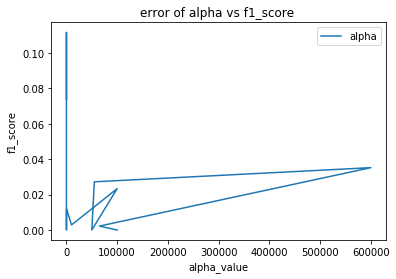

In [28]:
plt.plot(alpha_list,result['split0_test_score'],label='alpha')
plt.title("error of alpha vs f1_score ")
plt.xlabel('alpha_value')
plt.ylabel('f1_score')
plt.legend()
plt.show()

Conclusion

In [29]:
from prettytable import PrettyTable
x = PrettyTable()

In [30]:
x.field_names = ["model_name", "best alpha"]

In [31]:
x.add_row(["BOW",gs2.best_params_])
x.add_row(["sgd",gs3.best_params_])

In [32]:
print(x)

+------------+-----------------------------+
| model_name |          best alpha         |
+------------+-----------------------------+
|    BOW     |     {'estimator__C': 1}     |
|    sgd     | {'estimator__alpha': 0.001} |
+------------+-----------------------------+


# RandomForest

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
classifier_4 = OneVsRestClassifier(RandomForestClassifier(n_estimators = 100,max_depth=50,n_jobs = -1,class_weight="balanced"),n_jobs = -1)

In [35]:
classifier_4.fit(x_train_multilabel, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=50, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
          n_jobs=-1)

In [36]:
predictions_4= classifier_4.predict(x_test_multilabel)
print("Accuracy for test:",metrics.accuracy_score(y_test, predictions_4))
print("Hamming loss for test",metrics.hamming_loss(y_test,predictions_4))

Accuracy for test: 0.0685
Hamming loss for test 0.003861


In [38]:
predictions_4= classifier_4.predict(x_train_multilabel)
print("Accuracy for train:",metrics.accuracy_score(y_train, predictions_4))
print("Hamming loss for train",metrics.hamming_loss(y_train,predictions_4))




Accuracy for train: 0.984375
Hamming loss for train 3.525e-05


# gradientBoosting

In [39]:
import xgboost as xgb

In [40]:
xgb_reg = xgb.XGBRegressor(n_estimators=100, max_depth=3)
classifier_5 = OneVsRestClassifier(xgb.XGBRegressor(n_estimators=30, max_depth=10),n_jobs = -1)
classifier_5.fit(x_train_multilabel, y_train)

OneVsRestClassifier(estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=30,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          n_jobs=-1)

In [41]:
predictions_5 = classifier_5.predict(x_test_multilabel)
print("Accuracy for test:",metrics.accuracy_score(y_test, predictions_5))
print("Hamming loss for test",metrics.hamming_loss(y_test,predictions_5))

Accuracy for test: 0.0415
Hamming loss for test 0.005991


In [42]:
predictions_5 = classifier_5.predict(x_train_multilabel)
print("Accuracy for train:",metrics.accuracy_score(y_train, predictions_5))
print("Hamming loss for train",metrics.hamming_loss(y_train,predictions_5))

Accuracy for train: 0.6985
Hamming loss for train 0.0007975


In [47]:
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, classifier_5.predict(x_test_multilabel), average='macro')
recall = recall_score(y_test, classifier_5.predict(x_test_multilabel), average='macro')
f1 = f1_score(y_test,  classifier_5.predict(x_test_multilabel), average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))


Micro-average quality numbers
Precision: 0.0062, Recall: 0.0041, F1-measure: 0.0045


/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Macro-average quality numbers
Precision: 0.0062, Recall: 0.0041, F1-measure: 0.0045


/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/saurav/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


# conclusion

1) i tried with sgd classifier with bow and n-grams=(1,4)
2) i have used logistic regression with n-grams=(1,4) and tune then using gridsearch cv with various range of alpha
3) i have used sgd classiier along with gridsearch  and tune then with various range of alpha
4) Accuracy does not seems to be good, so i used an ensemble model which is random forest(bagging approach)
 which decreases training time. When i used class_weight = "balanced" , then the accuracy of the model decreases and hamming loss increases.
5) After that i tried with gradient boosting , which is booting method with less number of depth of tree, so that model becomes underfit which is high bias and low variance.